In [1]:
import sys

sys.path.append("../src/lake_modelling/utils")

import lake_model as lm
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("ggplot")

# Explore Agder liming data

Statsforvalteren i Agder has provided historic data showing the amount of lime added to various Agder lakes in different years. Notebook 04a cleaned this dataset and linked it to lake properties so it can be used for modelling.

The data available are coarse - usually one water sample in the spring (before liming) and one in the autumn (after liming). The amounts of lime added are also highly variable and in some cases based on what has been added historically, rather than on a detailed assessment of lake-specific needs. Nevertheless, these data provide an approximate way to evaluate the model by testing whether its predictions are broadly in agreement with amounts of lime actually added.

## 1. Read historic liming data

In [2]:
# Read data for Agder alkes
ag_xl_path = r"../data/agder_liming_data_tidy_with_vannmiljo_ids.xlsx"
vm_xl_path = r"../data/vannmiljo_limed_lakes.xlsx"

lake_df = pd.read_excel(ag_xl_path, sheet_name="lake_props")

# Ogge is too big and complex to be simulated meaningfully
lake_df = lake_df.query("lake != 'OGGE'")

lime_df = pd.read_excel(ag_xl_path, sheet_name="lime_added")
lime_df = lime_df.query("(method == 'Båt') and (tonnes > 0)")

wc_df = pd.read_excel(vm_xl_path, sheet_name="data", decimal=",")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"])
wc_df.fillna({"depth1": 0}, inplace=True)
wc_df.fillna({"depth2": 0}, inplace=True)
wc_df["year"] = wc_df["sample_date"].dt.year
wc_df["month"] = wc_df["sample_date"].dt.month

lake_df.head()

,lake,kommune,nve_nr,utm,catch_area_m2,ann_runoff_m,ann_runoff_m3,mean_q_m3ps,lake_area_m2,max_depth_m,mean_depth_m,volume_m3,tau_years,vannmiljo_id
0,BEGERVANN,BIRKENES,10772,616792.0,4100000,1.00,4100000,0.13,760000,62.0,14.60,11096000,2.71,020-45503
1,BELLANDSTJERN,BIRKENES,10539,472860.0,2000000,1.00,2000000,0.06,185000,14.5,2.70,499500,0.25,020-45453
2,BJORVAtN,EVJE/HORNNES,10217,348940.0,5650000,1.20,6780000,0.21,420000,19.0,6.26,2629200,0.39,021-45407
3,FLEKEVATN,FROLAND,10164,601951.0,1400000,1.00,1400000,0.04,531000,12.0,3.50,1858500,1.33,020-45401
4,FØREVANN,FROLAND,1335,483982.0,10700000,1.05,11235000,0.36,1404000,24.0,5.95,8353800,0.74,020-41034


## 2. Lake modelling

The code below applies the lake model to each lake in the Agder dataset. Because the data from Statsforvalteren does not specify which lime product has been used, I will assume that all liming is carried out using `Standard Kalk Kat3`. Lake properties (surface area, mean depth, residence time etc.) are based on estimates from Statsforvalteren, while lake initial pH is based on the data in Vannmiljø. The model is optimised to find the amount of lime (in tonnes) needed to achieve a **pH target of 6 one year after liming**. This value is then compared to the actual lime amounts added historicall based on the Statsforvalteren data.

All lakes are assumed to have a `Fjell` flow profile and to belong to the middle TOC class (3 to 5 mg/l of TOC). Lime is applied `Wet` (i.e. from a boat) over half the lake surface area.

In [3]:
# Define functions to optimise lake model

def run_model(
    lime_dose,
    product,
    area,
    depth,
    tau,
    ph0,
    phin,
    flow_prof,
    meth,
    spr_prop,
    rate_const,
    act_const,
):
    prod = lm.LimeProduct(product)
    lake = lm.Lake(
        area=area,
        depth=depth,
        tau=tau,
        flow_prof=flow_prof,
        pH_lake0=ph0,
        pH_inflow=phin,
        toc_lake0=4,
    )
    model = lm.Model(
        lake,
        prod,
        lime_dose=lime_dose,
        lime_month=7,
        spr_meth=meth,
        spr_prop=spr_prop,
        F_sol=1,
        rate_const=rate_const,
        activity_const=act_const,
        ca_aq_sat=8.5,
        n_months=12,
    )
    df = model.run()

    return (model, df)


def residual(
    params,
    product,
    area,
    depth,
    tau,
    ph0,
    phin,
    flow_prof,
    meth,
    spr_prop,
    rate_const,
    act_const,
):
    lime_dose = params["lime_dose"].value
    model, df = run_model(
        lime_dose,
        product,
        area,
        depth,
        tau,
        ph0,
        phin,
        flow_prof,
        meth,
        spr_prop,
        rate_const,
        act_const,
    )
    final_ph = df["pH"].iloc[-1]
    residual = final_ph - 6.0

    return residual

In [4]:
# Define fixed liming parameters 
init_dose = 10
prod_name = "Standard Kalk Kat3"
flow_prof = "fjell"
meth = "wet"
spr_prop = 0.5
rate_const = 0.1
act_const = 0.1

# Number of data points in lake chemistry and lime addition datasets for each lake
chem_thresh = 10
lime_thresh = 5

In [5]:
res_dict = {
    "vannmiljo_id": [],
    "lake_name": [],
    "area_km2": [],
    "mean_depth_m": [],
    "tau_years": [],
    "n_chem_samples": [],
    "n_years_limed": [],
    "min_ph": [],
    "mean_ph": [],
    "max_ph": [],
    "min_lime_tonnes": [],
    "mean_lime_tonnes": [],
    "max_lime_tonnes": [],
    "std_lime_tonnes": [],
    "mod_lime_tonnes": [],
}
for idx, row in lake_df.iterrows():
    name = row["lake"]
    vm_id = row["vannmiljo_id"]
    nve_id = row["nve_nr"]
    area = row["lake_area_m2"] / 1e6
    depth = row["mean_depth_m"]
    tau = row["tau_years"]

    # Get lake chem
    lake_chem_df = wc_df.query("vannmiljo_id == @vm_id").copy()
    min_ph, mean_ph, max_ph = (
        lake_chem_df["value"].min(),
        lake_chem_df["value"].mean(),
        lake_chem_df["value"].max(),
    )

    # Get liming data
    lake_lime_df = lime_df.query("nve_nr == @nve_id").copy()
    min_lime, mean_lime, max_lime, std_lime = (
        lake_lime_df["tonnes"].min(),
        lake_lime_df["tonnes"].mean(),
        lake_lime_df["tonnes"].max(),
        lake_lime_df["tonnes"].std(),
    )

    if (len(lake_chem_df) > chem_thresh) and (len(lake_lime_df) > lime_thresh):
        if min_ph < 4.5:
            ph0 = phin = 4.5
        else:
            ph0 = phin = min_ph
        params = lmfit.Parameters()
        params.add("lime_dose", value=init_dose, min=0, max=85)
        result = lmfit.minimize(
            residual,
            params,
            args=(
                prod_name,
                area,
                depth,
                tau,
                ph0,
                phin,
                flow_prof,
                meth,
                spr_prop,
                rate_const,
                act_const,
            ),
        )
        optimal_dose = result.params["lime_dose"].value
        model, df = run_model(
            result.params["lime_dose"].value,
            prod_name,
            area,
            depth,
            tau,
            ph0,
            phin,
            flow_prof,
            meth,
            spr_prop,
            rate_const,
            act_const,
        )
        lime_tonnes = spr_prop * model.lake.volume * optimal_dose / 1e9

        res_dict["vannmiljo_id"].append(vm_id)
        res_dict["lake_name"].append(name)
        res_dict["area_km2"].append(area)
        res_dict["mean_depth_m"].append(depth)
        res_dict["tau_years"].append(tau)
        res_dict["n_chem_samples"].append(len(lake_chem_df))
        res_dict["n_years_limed"].append(len(lake_lime_df))
        res_dict["min_ph"].append(min_ph)
        res_dict["mean_ph"].append(mean_ph)
        res_dict["max_ph"].append(max_ph)
        res_dict["min_lime_tonnes"].append(min_lime)
        res_dict["mean_lime_tonnes"].append(mean_lime)
        res_dict["max_lime_tonnes"].append(max_lime)
        res_dict["std_lime_tonnes"].append(std_lime)
        res_dict["mod_lime_tonnes"].append(lime_tonnes)

res_df = pd.DataFrame(res_dict)
res_df

,vannmiljo_id,lake_name,area_km2,mean_depth_m,tau_years,n_chem_samples,n_years_limed,min_ph,mean_ph,max_ph,min_lime_tonnes,mean_lime_tonnes,max_lime_tonnes,std_lime_tonnes,mod_lime_tonnes
0,020-45503,BEGERVANN,0.760,14.60,2.71,62,13,4.69,6.043871,6.80,10.0,35.192308,87.5,29.980229,25.512487
1,020-45453,BELLANDSTJERN,0.185,2.70,0.25,49,21,4.37,6.137959,7.12,9.0,18.042857,53.0,10.326111,18.185939
2,021-45407,BJORVAtN,0.420,6.26,0.39,68,24,4.32,6.106618,7.22,10.0,22.833333,64.0,17.987113,40.909803
3,020-45401,FLEKEVATN,0.531,3.50,1.33,53,9,4.55,6.195849,7.20,12.9,21.677778,63.0,16.171022,6.399616
4,020-41034,FØREVANN,1.404,5.95,0.74,59,28,4.23,5.800339,7.10,25.0,42.314286,143.0,30.098834,50.095549
5,019-45475,GANGVATN,0.455,6.55,1.32,47,12,5.10,6.130000,8.59,8.0,20.750000,48.0,12.787316,8.199524
6,020-39976,HAUKOMVATN,1.480,16.90,1.13,50,26,4.41,5.896200,6.67,40.0,69.061538,209.0,41.258629,98.728646
7,019-45424,HÅVATN,0.725,18.40,4.45,57,6,5.17,6.103860,6.53,15.0,22.333333,28.0,4.521357,21.798610
8,019-41519,HUNSDALSVANN,0.360,8.00,1.15,51,8,4.98,6.142353,6.93,13.0,27.600000,49.0,14.709375,9.250347
9,018-45236,KALLBERGSVANN,0.570,5.10,0.26,60,15,5.13,6.230500,7.24,15.0,49.933333,116.0,34.204149,72.419125


## 3. Plot results

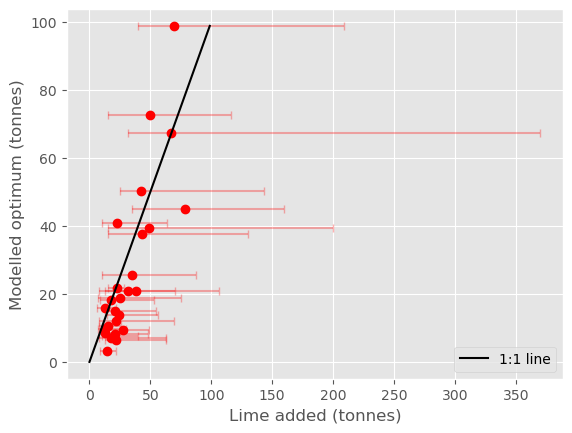

In [6]:
errors = [
    res_df["mean_lime_tonnes"] - res_df["min_lime_tonnes"],
    res_df["max_lime_tonnes"] - res_df["mean_lime_tonnes"],
]
plt.errorbar(
    res_df["mean_lime_tonnes"],
    res_df["mod_lime_tonnes"],
    xerr=errors,
    fmt="none",
    color="red",
    capsize=3,
    alpha=0.3,
)
plt.plot(res_df["mean_lime_tonnes"], res_df["mod_lime_tonnes"], "ro")
plt.plot(
    [0, res_df["mod_lime_tonnes"].max()],
    [0, res_df["mod_lime_tonnes"].max()],
    "k-",
    label="1:1 line",
)
plt.xlabel("Lime added (tonnes)")
plt.ylabel("Modelled optimum (tonnes)")
plt.legend(loc="lower right")

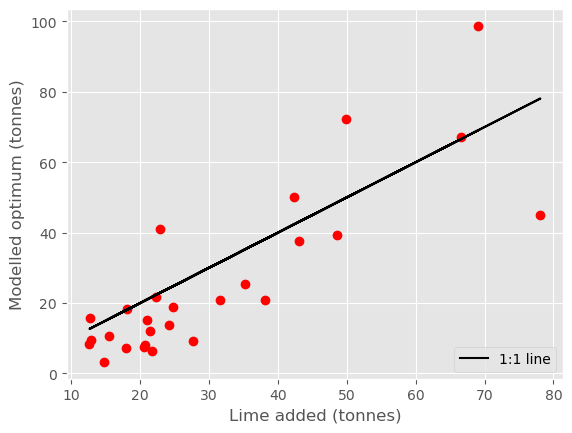

In [7]:
plt.plot(res_df["mean_lime_tonnes"], res_df["mod_lime_tonnes"], "ro")
plt.plot(res_df["mean_lime_tonnes"], res_df["mean_lime_tonnes"], "k-", label="1:1 line")
plt.xlabel("Lime added (tonnes)")
plt.ylabel("Modelled optimum (tonnes)")
plt.legend(loc="lower right")

Based on the plots above, it is clear there is a lot of variation in the amounts of lime applied historically, even at the same location. There is a generally positive correlation between the modelled optimum dose and the mean amount added, but the historic data is so noisy that a robust comparison is difficult. 

There is some evidence on the plot above that the modelled optimum is generally slightly lower than the amounts actually applied. However, this is expected because in practice liming strategies often include a "sikkerhetsmargin", where slightly more lime than needed is added to ensure the desired outcome is achieved.